In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchvision.models import resnet18

import numpy as np
import matplotlib.pyplot as plt

import time
import os
import copy

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
# Configuration
data_dir = '../../dataset/train-curat-dataset'

In [3]:
model_name = 'resnet18' 
num_classes = 7
batch_size = 16
num_epochs = 200
feature_extract = True
 
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
# Create training and validation dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print(class_names)
dataset_sizes

['algae', 'major_crack', 'minor_crack', 'peeling', 'plain', 'spalling', 'stain']


{'train': 2380, 'val': 793, 'test': 792}

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history


In [7]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [8]:
 #initilize the rasnet18 model
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0
 
    if model_name == "resnet18":
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
 
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [9]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
 
# Print the model architecture
#print(model_ft)

# Send the model to GPU
model_ft = model_ft.to(device)

/home/user/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
'''
Gather the parameters to be optimized/updated in this run. If we are
fine-tuning we will be updating all parameters. However, if we are
doing feature extract method, we will only update the parameters
that we have just initialized, i.e. the parameters with requires_grad
is True
'''
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t", name)
 
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
 
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 fc.weight
	 fc.bias


In [23]:
# Plot training and validation accuracy and loss
def plot_training_history(train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist, num_epochs):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc_hist, label='Training Accuracy')
    plt.plot(epochs, val_acc_hist, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss_hist, label='Training Loss')
    plt.plot(epochs, val_loss_hist, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


In [24]:
###
# Train and evaluate
model_ft, train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs)
 

Epoch 0/199
----------
train Loss: 1.5086 Acc: 0.4496
val Loss: 1.0198 Acc: 0.7251
Epoch 1/199
----------
train Loss: 1.0419 Acc: 0.6752
val Loss: 0.8240 Acc: 0.7339
Epoch 2/199
----------
train Loss: 0.8669 Acc: 0.7311
val Loss: 0.7004 Acc: 0.8071
Epoch 3/199
----------
train Loss: 0.7879 Acc: 0.7487
val Loss: 0.6642 Acc: 0.7970
Epoch 4/199
----------
train Loss: 0.7024 Acc: 0.7752
val Loss: 0.6049 Acc: 0.8197
Epoch 5/199
----------
train Loss: 0.6919 Acc: 0.7866
val Loss: 0.6015 Acc: 0.8134
Epoch 6/199
----------
train Loss: 0.6670 Acc: 0.7857
val Loss: 0.5985 Acc: 0.8083
Epoch 7/199
----------
train Loss: 0.6455 Acc: 0.7807
val Loss: 0.5602 Acc: 0.8260
Epoch 8/199
----------
train Loss: 0.6260 Acc: 0.7937
val Loss: 0.5536 Acc: 0.8260
Epoch 9/199
----------
train Loss: 0.6110 Acc: 0.7899
val Loss: 0.5537 Acc: 0.8172
Epoch 10/199
----------
train Loss: 0.5937 Acc: 0.8088
val Loss: 0.5587 Acc: 0.8285
Epoch 11/199
----------
train Loss: 0.6089 Acc: 0.7958
val Loss: 0.5240 Acc: 0.8411
Ep

In [25]:
# Save the best model weights
torch.save(model_ft.state_dict(), 'building_orig_resnet18_weights.pth')

In [26]:
train_acc_hist = torch.tensor(train_acc_hist)
val_acc_hist = torch.tensor(val_acc_hist)
train_loss_hist = torch.tensor(train_loss_hist)
val_loss_hist = torch.tensor(val_loss_hist)

train_acc_hist = train_acc_hist.cpu()
val_acc_hist = val_acc_hist.cpu()
train_loss_hist = train_loss_hist.cpu()
val_loss_hist = val_loss_hist.cpu()

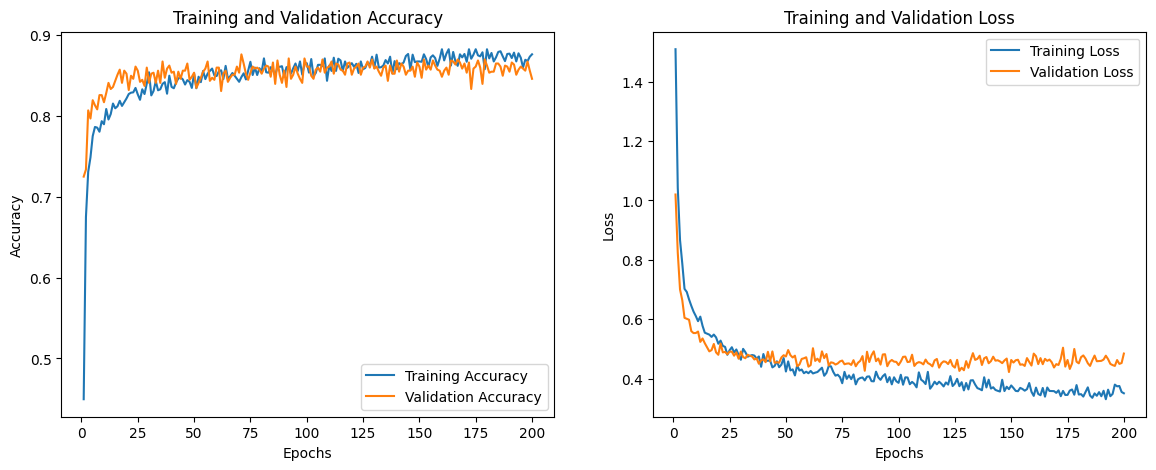

In [27]:
# Plot training and validation accuracy and loss
plot_training_history(train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist, num_epochs)


In [33]:
# Evaluate the model on test data
model_ft.eval()
test_corrects = 0
all_preds = []
all_labels = []
 
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
 
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
 
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    test_corrects += torch.sum(preds == labels.data)
 
test_acc = test_corrects.double() / dataset_sizes['test']
print('Test Accuracy: {:.4f}'.format(test_acc))
 
# Generate confusion matrix and classification report
conf_mat = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds, target_names=class_names)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", class_report)

Test Accuracy: 0.8308
Confusion Matrix:
 [[110   4   0   3   3   2   2]
 [  1  91  14   3   3   1   3]
 [  0  16  96   3   6   0   3]
 [  1   5   2  87   0   3   6]
 [  0   0   0   0 118   0   2]
 [  2   4   1   7   2  78   6]
 [  3   0   6   7   5   5  78]]
Classification Report:
               precision    recall  f1-score   support

       algae       0.94      0.89      0.91       124
 major_crack       0.76      0.78      0.77       116
 minor_crack       0.81      0.77      0.79       124
     peeling       0.79      0.84      0.81       104
       plain       0.86      0.98      0.92       120
    spalling       0.88      0.78      0.83       100
       stain       0.78      0.75      0.76       104

    accuracy                           0.83       792
   macro avg       0.83      0.83      0.83       792
weighted avg       0.83      0.83      0.83       792



In [43]:
import pandas as pd

# Convert the labels and predictions to their corresponding class names
actual_class_names = [class_names[label] for label in all_labels]
predicted_class_names = [class_names[pred] for pred in all_preds]

# Create the DataFrame
res = pd.DataFrame({"actual": actual_class_names, "predicted": predicted_class_names})

#res = pd.DataFrame( {"actual": all_labels, "predicted": all_preds})
print(res)
res.to_csv('resnet18_curat_results.csv', index=False)

          actual    predicted
0    major_crack  major_crack
1          stain        stain
2    major_crack  major_crack
3    minor_crack  minor_crack
4        peeling        algae
..           ...          ...
787      peeling      peeling
788        stain        plain
789  major_crack        plain
790  major_crack  minor_crack
791  minor_crack  minor_crack

[792 rows x 2 columns]


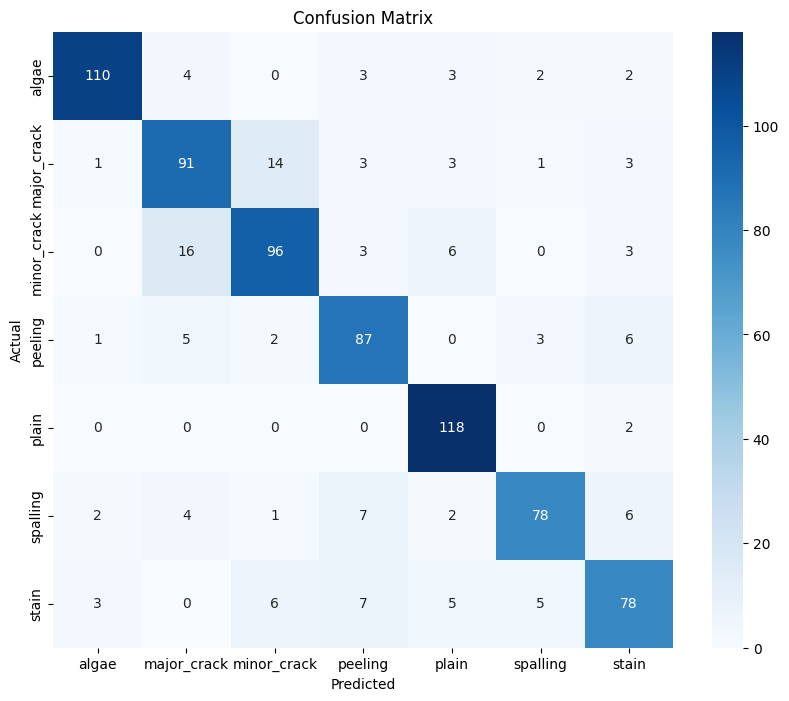

In [34]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig('building_origin_resnet18_confusion_matrix.png')
plt.show()
 


In [41]:
def visualize_model(model, dataloaders, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 12))  # Increase the figure size
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(2, 2, images_so_far)  # Create a 3x3 grid of subplots
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                plt.imshow(inputs.cpu().data[j].numpy().transpose((1, 2, 0)))
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
    
    model.train(mode=was_training)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8033988].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9876702..1.5071026].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9306722..1.5942485].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3130406..2.64].


Accuracy: 0.8308
Precision: [0.94017094 0.75833333 0.80672269 0.79090909 0.86131387 0.87640449
 0.78      ]
Recall: [0.88709677 0.78448276 0.77419355 0.83653846 0.98333333 0.78
 0.75      ]
F1 Score: [0.91286307 0.77118644 0.79012346 0.81308411 0.91828794 0.82539683
 0.76470588]


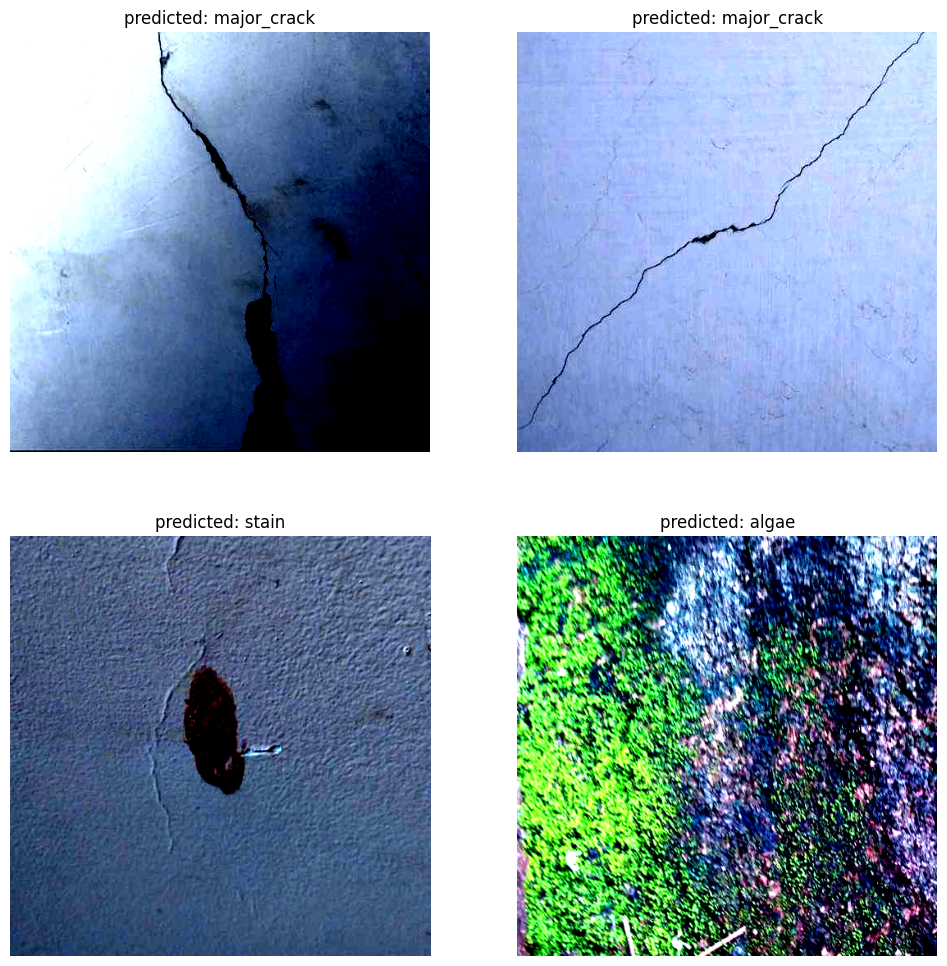

In [42]:
# Visualize some predictions
visualize_model(model_ft, dataloaders)
 
# Compute and display evaluation metrics
y_true = np.array(all_labels)
y_pred = np.array(all_preds)
 
accuracy = np.mean(y_true == y_pred)
precision = np.diag(conf_mat) / np.sum(conf_mat, axis=0)
recall = np.diag(conf_mat) / np.sum(conf_mat, axis=1)
f1_score = 2 * precision * recall / (precision + recall)
 
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
 
# Ensure the confusion matrix and the classification report are saved
with open('origin_resnet18_classification_report.txt', 'w') as f:
    f.write(f"Classification Report:\n{class_report}\n")